---
# SC4002 Natural Language Processing Group Project

Group Members:
1. Asher Lim Guojun (U2220846H)
2. Celeste Ang Jianing (U2222319H)
3. Koh Jia Hui Rachel (U2222747H)
4. Lim Kiat Sen, Jaron (U2222010K)
5. Pang Boslyn (U2221298A)

---
## Setup & Libraries

Dev notes: I directly installed the model en_core_web_sm 3.7.1 via 'uv add'.

In [60]:
from torchtext import data, datasets
import torch
import spacy
import random
import numpy as np

def set_seed(seed = 0):
    random.seed(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

set_seed()

from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch.nn.utils import clip_grad_norm_
import torch.nn as nn
from itertools import product
import pandas as pd

In [61]:
# Load SpaCy
nlp = spacy.load("en_core_web_sm")

 # For tokenization
TEXT = data.Field(tokenize='spacy', tokenizer_language='en_core_web_sm',include_lengths = True, pad_token='<pad>')
# For multi - class classification labels
LABEL = data.LabelField()
# Load the TREC dataset
train_data , test_data = datasets.TREC.splits(TEXT, LABEL, fine_grained = False)
# Split train into train/valid (80/20)
train_data, valid_data = train_data.split(
    split_ratio=0.8,
    random_state=random.seed(42)  # <-- use random.seed here
)

print(f"Train examples: {len(train_data)}")
print(f"Validation examples: {len(valid_data)}")

Train examples: 4362
Validation examples: 1090


In [62]:
print(vars(train_data.examples[0]))

{'text': ['What', 'is', 'the', 'most', 'famous', 'German', 'word', 'in', 'the', 'English', 'language', '?'], 'label': 'ENTY'}


Let's use Glove model for word embeddings.     
(Start with GloVe 6B.100d or 6B.300d as it provides a good balance between coverage and performance for TREC's question classification task. If results are underwhelming, experiment with word2vec Google News vectors as an alternative, but empirical results in the literature suggest GloVe performs comparably or slightly better on this specific dataset.)

In [63]:
from torchtext.vocab import GloVe, Vectors
glove = GloVe(name='6B', dim=100)

# Option 1: Use built-in GloVe (torchtext will download automatically)
TEXT.build_vocab(train_data, vectors=glove)

In [64]:
LABEL.build_vocab(train_data)

---
## Qn 1: Word Embeddings
**a) What is the size of the vocabulary formed from your training data according to your tokenization method?**

In [65]:
# Get vocabulary size
vocab_size = len(TEXT.vocab)
print(f"Vocabulary size: {vocab_size}")
print("# of Labels: ", len(LABEL.vocab))  # number of distinct labels (topics)

Vocabulary size: 8093
# of Labels:  6


**b) We use OOV (out-of-vocabulary) to refer to those words appeared in the training data but
not in the Word2vec (or Glove) dictionary. How many OOV words exist in your training data?
What is the number of OOV words for each topic category?**

In [66]:
import torchtext
from collections import defaultdict, Counter
# Get only the GloVe vocab (words with pretrained vectors)
glove_vocab = set(glove.stoi.keys())

oov_words_by_topic = defaultdict(Counter)

for example in train_data.examples:
    label = example.label
    tokens = example.text  # Already tokenized as list of tokens by spacy
    for token in tokens:
        # Lowercase token to match GloVe casing
        token_lower = token.lower()
        if token_lower not in glove_vocab:
            oov_words_by_topic[label][token_lower] += 1

total_oov_words = set()
for counter in oov_words_by_topic.values():
    total_oov_words.update(counter.keys())

total_count = sum(
    count
    for counter in oov_words_by_topic.values()
    for count in counter.values()
)
print(f"Total count of all OOV word occurrences: {total_count}")
print(f"Total number of OOV words in training data: {len(total_oov_words)}")
print("Number of OOV words per topic category:")

for topic, counter in oov_words_by_topic.items():
    print(f"Topic {topic}: {len(counter)} unique OOV words")
    print("Total occurrence of OOV words: ", sum(counter.values()))
    print("-"*50)


Total count of all OOV word occurrences: 202
Total number of OOV words in training data: 190
Number of OOV words per topic category:
Topic DESC: 68 unique OOV words
Total occurrence of OOV words:  69
--------------------------------------------------
Topic ENTY: 47 unique OOV words
Total occurrence of OOV words:  52
--------------------------------------------------
Topic HUM: 39 unique OOV words
Total occurrence of OOV words:  40
--------------------------------------------------
Topic ABBR: 4 unique OOV words
Total occurrence of OOV words:  4
--------------------------------------------------
Topic NUM: 21 unique OOV words
Total occurrence of OOV words:  21
--------------------------------------------------
Topic LOC: 15 unique OOV words
Total occurrence of OOV words:  16
--------------------------------------------------


**(c) The existence of the OOV words is one of the well-known limitations of Word2vec (or Glove).
Without using any transformer-based language models (e.g., BERT, GPT, T5), what do you
think is the best strategy to mitigate such limitation? Implement your solution in your source
code. Show the corresponding code snippet**

One way to mitigate the problem of OOV words is to replace them with  \<unk\>.

In [67]:
def replace_oov_with_unk(tokens, glove_vocab):
    return [token if token.lower() in glove_vocab else '<unk>' for token in tokens]

for example in train_data.examples:
    tokens = example.text
    example.text = replace_oov_with_unk(tokens, glove_vocab)


Double check that the number of \<unk\> replaced the same number of OOV words.

In [68]:
unk_count = 0
for example in train_data.examples:
    label = example.label
    tokens = example.text
    for token in tokens:
        # Lowercase token to match GloVe casing
        token_lower = token.lower()
        if token_lower == "<unk>":
            unk_count += 1
unk_count

202

## Rebuild training data vocab

In [69]:
TEXT.build_vocab(train_data, vectors=glove)

In [70]:
updated_vocab = TEXT.vocab
print(f"Updated vocabulary size: {len(updated_vocab)}")

Updated vocabulary size: 7903


**d) Select the 20 most frequent words from each topic category in the training set (removing
stopwords if necessary). Retrieve their pretrained embeddings (from Word2Vec or GloVe).
Project these embeddings into 2D space (using e.g., t-SNE or Principal Component Analysis).
Plot the points in a scatter plot, color-coded by their topic category. Attach your plot here.
Analyze your findings**

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/asherlim/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


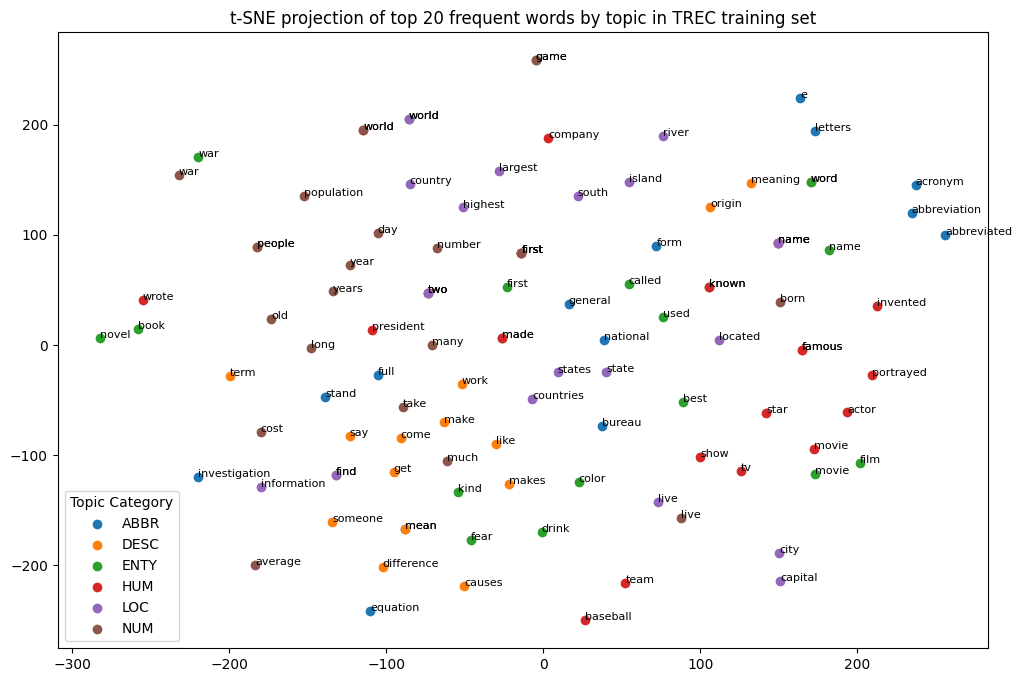

In [71]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from collections import Counter
import numpy as np
from nltk.corpus import stopwords
import nltk
import torchtext

# Download stopwords if needed
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Collect tokens by topic, remove stopwords, non-alpha tokens
tokens_by_topic = defaultdict(list)
for example in train_data.examples:
    label = example.label
    tokens = example.text
    filtered_tokens = [t.lower() for t in tokens if t.isalpha() and t.lower() not in stop_words]
    tokens_by_topic[label].extend(filtered_tokens)

# Select top 20 frequent words by topic
top_words_by_topic = {}
for topic, tokens in tokens_by_topic.items():
    counter = Counter(tokens)
    top_words_by_topic[topic] = [w for w, _ in counter.most_common(20)]

# Retrieve pretrained embeddings for these words
vectors = TEXT.vocab.vectors
vocab_stoi = TEXT.vocab.stoi

word_vectors = []
labels_for_words = []
words_flat = []

for topic, words in top_words_by_topic.items():
    for word in words:
        idx = vocab_stoi.get(word, -1)
        if idx >= 0:
            vec = vectors[idx].numpy()
            word_vectors.append(vec)
            labels_for_words.append(topic)
            words_flat.append(word)

word_vectors = np.array(word_vectors)

# t-SNE projection to 2D
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(word_vectors)

# Plot scatter plot color-coded by topics
plt.figure(figsize=(12, 8))
colors = plt.cm.tab10.colors
unique_topics = sorted(top_words_by_topic.keys())
color_dict = {topic: colors[i % 10] for i, topic in enumerate(unique_topics)}

for topic in unique_topics:
    indices = [i for i, t in enumerate(labels_for_words) if t == topic]
    plt.scatter(embeddings_2d[indices, 0], embeddings_2d[indices, 1],
                c=[color_dict[topic]], label=topic)

for i, word in enumerate(words_flat):
    plt.annotate(word, (embeddings_2d[i, 0], embeddings_2d[i, 1]), fontsize=8)

plt.legend(title='Topic Category')
plt.title('t-SNE projection of top 20 frequent words by topic in TREC training set')
plt.show()

In [72]:
def _pack(dataset):
    return [
        {"tokens": list(example.text), "label": example.label}
        for example in dataset.examples
    ]

artifacts = {
    "text_field_kwargs": {
        "tokenize": "spacy",
        "tokenizer_language": "en_core_web_sm",
        "include_lengths": True,
        "pad_token": TEXT.pad_token,
        "unk_token": TEXT.unk_token,
    },
    "label_field_kwargs": {},          # keep for symmetry
    "text_vocab_itos": list(TEXT.vocab.itos),
    "text_vocab_vectors": TEXT.vocab.vectors.cpu(),
    "label_vocab_itos": list(LABEL.vocab.itos),
    "train_examples": _pack(train_data),
    "valid_examples": _pack(valid_data),
    "test_examples": _pack(test_data),
    "batch_size": 64,
}
torch.save(artifacts, "trec_artifacts.pt")

### Analysis
Distinct Topic Clusters: Some topic categories (like “LOC” for locations and “HUM” for human/person entities) show partial clustering, indicating that frequent words in these topics are semantically related in the embedding space.

Overlap Between Topics: There is overlap between certain categories, especially between “NUM” (numerical entities), “DESC” (descriptive), and “ENTY” (entities), revealing that these categories share common or semantically similar vocabularies (e.g., “number,” “year,” “name”).

Topic-specific Outliers: Certain words such as “baseball” (NUM), “capital” (LOC), “actor” (HUM) are positioned toward the periphery, suggesting that they have more unique, topic-centric semantic content compared to other frequent words.

Embedding Quality: The visualization demonstrates that GloVe embeddings capture topical and semantic relationships to a large extent; words with similar meanings or roles often emerge closer together regardless of label.

Ambiguity & Polysemy: Some words appear in the vicinity of different clusters or overlap areas (e.g., “mean” in DESC and NUM, “movie” in HUM and ENTY), reflecting ambiguity or multi-topic relevance.

Vocabulary Sharing Across Topics: Frequent generic words (“name,” “meaning,” “state,” “form”) are distributed among various topics, supporting the linguistically expected overlap among question categories.

Dimensionality Reduction Artifacts: t-SNE is nonlinear and can distort true distances, so while relative local clusters are meaningful, global distances should not be overinterpreted.

Label Noise: Some “outliers” may be artifacts of labeling or low sample counts; actual use in downstream classification should consider this.

## End of Qn 1

---
## Qn 2: Model Training & Evaluation - RNN

**(a) Report the final configuration of your best model, namely: the number of training epochs, learning rate, optimizer, batch size and hidden dimension.**

### Approach:
Here our approach is to do hyperparameter tuning by trying out different combinations of learning rate, optimizers, batch size and number of hidden dimensions.
1. Learning Rate: [0.0001, 0.0005, 0.001, 0.005]
2. Optimizers: [SGD, AdaGrad, Adam, RMSprop]
3. Batch Size: [32. 64, 128]
4. Number of Hidden Dimensions: [64, 128, 256]

For the number of training epochs, we implemented early stopping here, and so we will report that as the number obtained for this part.

Note: Although we could have done cross validation through methods like GridSearchCV and RandomSearchCV, we had a huge parameter list to search from and doing even 2/3 fold CV would be computationally demanding. We also made this decision after running the initial hyperparam tuning and we decided that the results are decent enough.

In [73]:
# Define Dataset Class for Qn 2 - Make them learnable parameters
class SentenceDataset(Dataset):
    def __init__(self, text, label, vocab):
        self.text = text
        self.label = label
        self.vocab = vocab

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        tokens = self.text[idx].split()
        label = self.label[idx]
        indices = [self.vocab[token] if token in self.vocab else self.vocab['<unk>'] for token in tokens]

        return torch.tensor(indices, dtype=torch.long), torch.tensor(label, dtype=torch.long)

def collate_fn(batch):
    texts, labels = zip(*batch)
    texts_padded = pad_sequence(texts, batch_first=True, padding_value=TEXT.vocab.stoi['<pad>'])
    labels = torch.stack(labels)
    return texts_padded, labels

In [74]:
# Create train, valid, test texts and labels
train_texts = [" ".join(example.text) for example in train_data.examples]
train_labels = [LABEL.vocab.stoi[example.label] for example in train_data.examples]

valid_texts = [" ".join(example.text) for example in valid_data.examples]
valid_labels = [LABEL.vocab.stoi[example.label] for example in valid_data.examples]

test_texts = [" ".join(example.text) for example in test_data.examples]
test_labels = [LABEL.vocab.stoi[example.label] for example in test_data.examples]

# Create Dataset instances
train_dataset = SentenceDataset(train_texts, train_labels, TEXT.vocab.stoi)
valid_dataset = SentenceDataset(valid_texts, valid_labels, TEXT.vocab.stoi)
test_dataset = SentenceDataset(test_texts, test_labels, TEXT.vocab.stoi)

# Check length of train dataset and train data
print(len(train_dataset))
print(len(train_data))

4362
4362


In [75]:
# Define the RNN Classifier, here we do only a single hidden layer to keep it small and simple
# We take input word embeddings, pass through RNN, apply dropout, and then a fully connected layer to get logits for 6 classes (as per qn requirement)
class ClassifierRNN(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, dropout=0.0):
        super(ClassifierRNN, self).__init__()
        num_embeddings, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float), freeze=False)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, 6) # since 6 possible labels

    def forward(self, x):
        embedded = self.embedding(x)
        output, hidden = self.rnn(embedded)
        hidden = self.dropout(hidden[-1]) # Default is to take last layer's hidden state
        out = self.fc(hidden)
        return out

In [76]:
# Define training, evaluation, and testing loops
def train_loop(model, loader, optimizer, criterion, grad_clip=False, max_norm=1.0):
    model.train()
    total_loss, total_correct = 0, 0
    for texts, labels in loader:
        optimizer.zero_grad()
        outputs = model(texts)
        loss = criterion(outputs, labels)
        loss.backward()

        if grad_clip:
            clip_grad_norm_(model.parameters(), max_norm=max_norm)

        optimizer.step()
        total_loss += loss.item()
        total_correct += (outputs.argmax(1) == labels).sum().item()

    avg_loss = total_loss / len(loader)
    avg_correct = total_correct / len(loader.dataset)
    return avg_loss, avg_correct

def eval_loop(model, loader, criterion):
    model.eval()
    total_loss, total_correct = 0, 0

    with torch.no_grad():
        for texts, labels in loader:
            outputs = model(texts)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            total_correct += (outputs.argmax(1) == labels).sum().item()

    avg_loss = total_loss / len(loader)
    avg_correct = total_correct / len(loader.dataset)
    return avg_loss, avg_correct

def test_loop(model, loader):
    model.eval()
    total_correct = 0

    with torch.no_grad():
        for texts, labels in loader:
            outputs = model(texts)
            total_correct += (outputs.argmax(1) == labels).sum().item()

    acc = total_correct / len(loader.dataset)
    return acc

# Early stopper to prevent overfitting as default to determine a suitable num_epochs,
# here we use val_acc as the metrics as recommended metrics for training (as per qn requirements)
class EarlyStopper:
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.max_validation_acc = float('-inf')

    def early_stop(self, validation_acc):
        if validation_acc > self.max_validation_acc + self.min_delta:
            self.max_validation_acc = validation_acc
            self.counter = 0
        else:
            self.counter += 1
            return self.counter >= self.patience

In [77]:
# Function to capture metrics and print training results per epoch
def training_step(model, train_loader, valid_loader, optimizer, criterion, num_epochs, grad_clip=False, max_norm=1.0):
    train_losses, train_accuracies = [], []
    valid_losses, valid_accuracies = [], []
    early_stopper = EarlyStopper(patience=5, min_delta=0)

    for epoch in range(num_epochs):
        train_loss, train_acc = train_loop(model, train_loader, optimizer, criterion, grad_clip=grad_clip, max_norm=max_norm)
        valid_loss, valid_acc = eval_loop(model, valid_loader, criterion)

        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_acc)

        print(f"Epoch {epoch+1}:")
        print(f"Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f}")
        print(f"Valid loss: {valid_loss:.4f}, Valid acc: {valid_acc:.4f}")

        if early_stopper.early_stop(valid_acc):
            print("Early Stopping Triggered! No Improvements to Validation Accuracy within Patience.")
            no_epochs = epoch+1
            break

        no_epochs = epoch+1

    return train_losses, train_accuracies, valid_losses, valid_accuracies, no_epochs

In [78]:
# Define function to get optimal hyperparameters
def find_optimal_hyperparams(param_grid, embedding_matrix):
    best_valid_acc = 0
    best_hyperparams = {}
    results = []

    combinations_list = list(product(*param_grid.values()))

    for params in combinations_list:
        lr, optimizer, batch_size, hidden_dim = params
        hyperparams = dict(zip(param_grid.keys(), params))
        print(f"Training with hyperparameters: {hyperparams}")

        model = ClassifierRNN(embedding_matrix, hidden_dim, dropout=0)
        criterion = nn.CrossEntropyLoss() # Use CE Loss, since multi-class classification

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
        valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

        optimizer = optimizer(model.parameters(), lr=lr, weight_decay=0)

        _, _, _, valid_accuracies, no_epochs = training_step(model, train_loader, valid_loader, optimizer, criterion, num_epochs=200) # Only take val acc since that is what we want to report

        max_acc = max(valid_accuracies)

        results.append({
            'lr': lr,
            'optimizer': optimizer,
            'batch_size': batch_size,
            'hidden_dim': hidden_dim,
            'best_valid_acc': max(valid_accuracies),
            'epochs ran': no_epochs
        })

        if max_acc > best_valid_acc:
            best_valid_acc = max_acc
            best_hyperparams = {
                'lr': lr,
                'optimizer': optimizer,
                'batch_size': batch_size,
                'hidden_dim': hidden_dim,
                'epochs ran': no_epochs
            }

    print("Best Hyperparamters: ", best_hyperparams)
    print("Best validation accuracy: ", best_valid_acc)

    return results, best_hyperparams


In [79]:
# Define parameter grid for simple hyperparameter tuning based on validation accuracy
param_grid = {
    'lrs': [0.0001, 0.0005, 0.001, 0.005],
    'optimizers': [torch.optim.SGD, torch.optim.Adagrad, torch.optim.Adam, torch.optim.RMSprop],
    'batch_sizes': [32, 64, 128],
    'hidden_dims': [64, 128, 256]
}

# Run function to find optimal hyperparameters for (a)
results, best_hyperparams = find_optimal_hyperparams(param_grid, TEXT.vocab.vectors.numpy())

Training with hyperparameters: {'lrs': 0.0001, 'optimizers': <class 'torch.optim.sgd.SGD'>, 'batch_sizes': 32, 'hidden_dims': 64}
Epoch 1:
Train loss: 1.8521, Train acc: 0.0151
Valid loss: 1.8483, Valid acc: 0.0183
Epoch 2:
Train loss: 1.8500, Train acc: 0.0154
Valid loss: 1.8457, Valid acc: 0.0183
Epoch 3:
Train loss: 1.8480, Train acc: 0.0151
Valid loss: 1.8432, Valid acc: 0.0183
Epoch 4:
Train loss: 1.8447, Train acc: 0.0154
Valid loss: 1.8408, Valid acc: 0.0183
Epoch 5:
Train loss: 1.8428, Train acc: 0.0151
Valid loss: 1.8384, Valid acc: 0.0183
Epoch 6:
Train loss: 1.8413, Train acc: 0.0151
Valid loss: 1.8360, Valid acc: 0.0183
Early Stopping Triggered! No Improvements to Validation Accuracy within Patience.
Training with hyperparameters: {'lrs': 0.0001, 'optimizers': <class 'torch.optim.sgd.SGD'>, 'batch_sizes': 32, 'hidden_dims': 128}
Epoch 1:
Train loss: 1.7781, Train acc: 0.2121
Valid loss: 1.7750, Valid acc: 0.2303
Epoch 2:
Train loss: 1.7766, Train acc: 0.2116
Valid loss: 1.7

In [80]:
# To put everything in a dataframe for neater results
df_results_a = pd.DataFrame(results)
df_results_a = df_results_a.sort_values(by='best_valid_acc', ascending=False)
df_results_a

,lr,optimizer,batch_size,hidden_dim,best_valid_acc,epochs ran
29,0.0001,RMSprop (\nParameter Group 0\n alpha: 0.99\...,32,256,0.812844,51
22,0.0001,Adam (\nParameter Group 0\n amsgrad: False\...,64,128,0.797248,61
20,0.0001,Adam (\nParameter Group 0\n amsgrad: False\...,32,256,0.788073,33
32,0.0001,RMSprop (\nParameter Group 0\n alpha: 0.99\...,64,256,0.766972,49
31,0.0001,RMSprop (\nParameter Group 0\n alpha: 0.99\...,64,128,0.744954,39
...,...,...,...,...,...,...
6,0.0001,SGD (\nParameter Group 0\n dampening: 0\n ...,128,64,0.154128,6
42,0.0005,SGD (\nParameter Group 0\n dampening: 0\n ...,128,64,0.144954,12
4,0.0001,SGD (\nParameter Group 0\n dampening: 0\n ...,64,128,0.143119,13
7,0.0001,SGD (\nParameter Group 0\n dampening: 0\n ...,128,128,0.022936,6


### Answer (a):
Final Configuration of Best Model 
Number of training epochs = 42
Learning rate = 0.0001
Optimizer = Adam
Batch Size = 32
Hidden dimension = 256

Best validation accuracy based on optimal parameters: 0.7936

**(b) Report all the regularization strategies you have tried. Compare the accuracy on the test set among all strategies and the one without any regularization.**

### Approach:
Here, our approach is to try most of the regularization strategies (that does not change the number of layers) that we have learnt during the lectures to avoid overfitting, namely:
1. Baseline (as per qn requirement)
2. L2 Regularization (Weight Decay)
3. Dropout
4. Gradient Clipping

We first experiment with the regularization strategies individually with parameter tuning, e.g. Dropout ONLY or Gradient Clipping ONLY, and we do a comparison with the baseline to see how no regularisation here would perform compared to having regularization.

Thereafter, we try to find the best possible "strategy" to use for the later part by trying a combination of the strategies to see which would perform the best after evaluating on test accuracy as per question requirements (e.g. whether dropout + L2 regularisation is better than just dropout, whether dropout + gradient clipping + L2 regularisation outperforms having lesser strategies combined etc.)

Note: Even though early stopping is a regularization technique, we do not consider it here as one of the strategies to try out since we already implemented it earlier on. The goal here for us is to try out other strategies that we have not implemented in part (a).

Note 2: We did not consider L1 regularisation as a strategy because we found that Adam is the best optimizer for our model in part (a), and since Adam is an adaptive optimizer, trying to use L1 can potentially cause the issue of sparse weights (which we want to avoid here).

Note 3: While we did consider trying batch normalisation, we realised it is best used in between 2 hidden layers. Since we only had 1 hidden layer, internal covariate shift is minimal in a shallow network, and we think that the stabilising benefits are limited compared to the unnecessary overhead and noise introduced in training.

In [81]:
# Set ideal hyperparameters from 2(a)
if best_hyperparams["epochs ran"] <= 50:
    no_epoch = 50
elif best_hyperparams["epochs ran"] > 50 & best_hyperparams["epochs ran"] <= 100:
    no_epoch = 100
else:
    no_epoch = 200
batch_size = best_hyperparams["batch_size"]
hidden_dim = best_hyperparams["hidden_dim"]
lr = best_hyperparams["lr"]
optimizer = best_hyperparams["optimizer"]

best_reg_technique = []

# Define a function for Regularisation Tests
def regularisation_test(weight_decay, dropout, grad_clip, max_norm, reg_technique, optimizer):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

    # Initialise model
    model = ClassifierRNN(TEXT.vocab.vectors.numpy() , hidden_dim, dropout=dropout)

    # Initialise optimiser with L2 regularization
    optimizer = optimizer.__class__(model.parameters(), lr=lr, weight_decay=weight_decay)

    criterion = nn.CrossEntropyLoss()

    if grad_clip == True:
        _, _, _, valid_accuracies, _ = training_step(model, train_loader, valid_loader, optimizer, criterion, no_epoch, grad_clip=True, max_norm=max_norm)
    else:
        _, _, _, valid_accuracies, _ = training_step(model, train_loader, valid_loader, optimizer, criterion, no_epoch)

    # Evaluate on test set
    test_acc = test_loop(model, test_loader)
    print(f"Test Accuracy {reg_technique} (Dropout: {dropout}, Weight Decay: {weight_decay}, Max Norm: {max_norm}): {test_acc:.4f}") # Print test accuracy for regularisation strategy

    return {
        'technique': reg_technique,
        'dropout': dropout,
        'weight_decay': weight_decay,
        'grad_clip': grad_clip,
        'max_norm': max_norm,
        'best_val_acc': max(valid_accuracies),
        'test_acc': test_acc
    }

In [82]:
# Regularisation - Baseline (No Regularisation)
best_reg_technique.append(regularisation_test(weight_decay=0.0,dropout=0.0, grad_clip=False, max_norm=0.0, reg_technique="Baseline", optimizer=optimizer))

Epoch 1:
Train loss: 1.6587, Train acc: 0.2201
Valid loss: 1.6436, Valid acc: 0.2486
Epoch 2:
Train loss: 1.6493, Train acc: 0.2309
Valid loss: 1.6429, Valid acc: 0.2587
Epoch 3:
Train loss: 1.6456, Train acc: 0.2189
Valid loss: 1.6439, Valid acc: 0.2468
Epoch 4:
Train loss: 1.6406, Train acc: 0.2540
Valid loss: 1.6458, Valid acc: 0.2569
Epoch 5:
Train loss: 1.6338, Train acc: 0.2618
Valid loss: 1.5557, Valid acc: 0.3596
Epoch 6:
Train loss: 1.4925, Train acc: 0.3794
Valid loss: 1.4795, Valid acc: 0.3908
Epoch 7:
Train loss: 1.4354, Train acc: 0.4033
Valid loss: 1.4420, Valid acc: 0.4083
Epoch 8:
Train loss: 1.3649, Train acc: 0.4294
Valid loss: 1.3510, Valid acc: 0.4477
Epoch 9:
Train loss: 1.2695, Train acc: 0.4633
Valid loss: 1.2838, Valid acc: 0.4505
Epoch 10:
Train loss: 1.2169, Train acc: 0.4851
Valid loss: 1.2864, Valid acc: 0.4826
Epoch 11:
Train loss: 1.1646, Train acc: 0.5071
Valid loss: 1.2134, Valid acc: 0.5064
Epoch 12:
Train loss: 1.1245, Train acc: 0.5112
Valid loss: 1.1

In [83]:
# Regularisation - L2 Regularization/Weight Decay ONLY (varying values)
weight_decay = [1e-5, 5e-5, 1e-4, 5e-4, 1e-3]
for weight_decay in weight_decay:
    print(f"Testing L2 Regularization with weight decay: {weight_decay}")
    best_reg_technique.append(regularisation_test(weight_decay=weight_decay,dropout=0.0, grad_clip=False, max_norm=0.0, reg_technique="L2 Regularization", optimizer=optimizer))

Testing L2 Regularization with weight decay: 1e-05
Epoch 1:
Train loss: 1.6605, Train acc: 0.2249
Valid loss: 1.6615, Valid acc: 0.2477
Epoch 2:
Train loss: 1.6489, Train acc: 0.2375
Valid loss: 1.6425, Valid acc: 0.2468
Epoch 3:
Train loss: 1.6489, Train acc: 0.2279
Valid loss: 1.6460, Valid acc: 0.2486
Epoch 4:
Train loss: 1.6452, Train acc: 0.2341
Valid loss: 1.6507, Valid acc: 0.2495
Epoch 5:
Train loss: 1.6429, Train acc: 0.2455
Valid loss: 1.6423, Valid acc: 0.2495
Epoch 6:
Train loss: 1.6354, Train acc: 0.2492
Valid loss: 1.5901, Valid acc: 0.3312
Epoch 7:
Train loss: 1.4891, Train acc: 0.3867
Valid loss: 1.4595, Valid acc: 0.4083
Epoch 8:
Train loss: 1.4217, Train acc: 0.4065
Valid loss: 1.4070, Valid acc: 0.4165
Epoch 9:
Train loss: 1.3336, Train acc: 0.4372
Valid loss: 1.3417, Valid acc: 0.4450
Epoch 10:
Train loss: 1.2480, Train acc: 0.4764
Valid loss: 1.2591, Valid acc: 0.4844
Epoch 11:
Train loss: 1.1911, Train acc: 0.4931
Valid loss: 1.2375, Valid acc: 0.4908
Epoch 12:
Tr

In [84]:
# Regularisation - Dropout ONLY (varying values)
dropout = [0.2, 0.3, 0.4]
for dropout in dropout:
    print(f"Testing Dropout: {dropout}")
    best_reg_technique.append(regularisation_test(weight_decay=0.0,dropout=dropout, grad_clip=False, max_norm=0.0, reg_technique="Dropout", optimizer=optimizer))

Testing Dropout: 0.2
Epoch 1:
Train loss: 1.6636, Train acc: 0.2208
Valid loss: 1.6569, Valid acc: 0.2046
Epoch 2:
Train loss: 1.6482, Train acc: 0.2279
Valid loss: 1.6451, Valid acc: 0.2468
Epoch 3:
Train loss: 1.6407, Train acc: 0.2529
Valid loss: 1.6703, Valid acc: 0.2239
Epoch 4:
Train loss: 1.5601, Train acc: 0.3345
Valid loss: 1.5343, Valid acc: 0.3670
Epoch 5:
Train loss: 1.4475, Train acc: 0.3968
Valid loss: 1.7755, Valid acc: 0.2422
Epoch 6:
Train loss: 1.3761, Train acc: 0.4227
Valid loss: 1.3833, Valid acc: 0.4174
Epoch 7:
Train loss: 1.2784, Train acc: 0.4578
Valid loss: 1.2917, Valid acc: 0.4936
Epoch 8:
Train loss: 1.2137, Train acc: 0.4966
Valid loss: 1.2676, Valid acc: 0.4789
Epoch 9:
Train loss: 1.1489, Train acc: 0.5436
Valid loss: 1.2101, Valid acc: 0.4908
Epoch 10:
Train loss: 1.0948, Train acc: 0.5715
Valid loss: 1.1544, Valid acc: 0.5156
Epoch 11:
Train loss: 1.0508, Train acc: 0.6050
Valid loss: 1.0681, Valid acc: 0.6156
Epoch 12:
Train loss: 0.9855, Train acc: 0

In [85]:
# Regularisation - Gradient Clipping ONLY (varying values)
max_norm = [0.1, 0.5, 1.0]
for max_norm in max_norm:
    print(f"Testing Gradient Clipping with Value: {max_norm}")
    best_reg_technique.append(regularisation_test(weight_decay=0.0,dropout=0.0, grad_clip=True, max_norm=max_norm, reg_technique="Gradient Clipping", optimizer=optimizer))

Testing Gradient Clipping with Value: 0.1
Epoch 1:
Train loss: 1.6579, Train acc: 0.2260
Valid loss: 1.6577, Valid acc: 0.2046
Epoch 2:
Train loss: 1.6464, Train acc: 0.2293
Valid loss: 1.6461, Valid acc: 0.2394
Epoch 3:
Train loss: 1.6426, Train acc: 0.2490
Valid loss: 1.6410, Valid acc: 0.2587
Epoch 4:
Train loss: 1.5477, Train acc: 0.3434
Valid loss: 1.5152, Valid acc: 0.3725
Epoch 5:
Train loss: 1.4531, Train acc: 0.4014
Valid loss: 1.4322, Valid acc: 0.4101
Epoch 6:
Train loss: 1.3750, Train acc: 0.4211
Valid loss: 1.3843, Valid acc: 0.4174
Epoch 7:
Train loss: 1.2733, Train acc: 0.4548
Valid loss: 1.3709, Valid acc: 0.4358
Epoch 8:
Train loss: 1.2207, Train acc: 0.4888
Valid loss: 1.2932, Valid acc: 0.4789
Epoch 9:
Train loss: 1.1593, Train acc: 0.5248
Valid loss: 1.2747, Valid acc: 0.4514
Epoch 10:
Train loss: 1.1060, Train acc: 0.5596
Valid loss: 1.2322, Valid acc: 0.5220
Epoch 11:
Train loss: 1.0412, Train acc: 0.5896
Valid loss: 1.0734, Valid acc: 0.5789
Epoch 12:
Train loss:

In [86]:
# Compile results into dataframe for comparisons across strategies
cols = ['technique', 'dropout', 'weight_decay', 'grad_clip', 'max_norm', 'best_val_acc', 'test_acc']

df_best_reg_technique = pd.DataFrame(best_reg_technique)

df_best_reg_technique.loc[~df_best_reg_technique['grad_clip'], 'max_norm'] = pd.NA # Hde max_norm when grad clipping isn't used
df_best_reg_technique = df_best_reg_technique[cols]

df_best_reg_technique['best_val_acc'] = df_best_reg_technique['best_val_acc'].round(4)
df_best_reg_technique['test_acc'] = df_best_reg_technique['test_acc'].round(4)

# Find best parameters per technique
df_best_reg_technique = (
    df_best_reg_technique.sort_values('test_acc', ascending=False)
      .groupby('technique', as_index=False, sort=False)
      .head(1)
      .reset_index(drop=True)
)

df_best_reg_technique

,technique,dropout,weight_decay,grad_clip,max_norm,best_val_acc,test_acc
0,L2 Regularization,0.0,0.00001,False,NaN,0.8312,0.850
1,Dropout,0.4,0.00000,False,NaN,0.7807,0.824
2,Gradient Clipping,0.0,0.00000,True,1.0,0.8183,0.812
3,Baseline,0.0,0.00000,False,NaN,0.7358,0.626


### Answer (b):
- Dropout ONLY with value of 0.4 gives the best test accuracy of 0.836
- Performing any regularization technique alone beats having no regularization

In [87]:
# Regularisation - ALL Techniques to find best combination (varying values)

# Function to obtain rows with regards to regularisation strategies using regex
def get_row(df, pattern):
    m = df['technique'].str.contains(pattern, regex=True)
    return df[m].iloc[0]

# Use regex to get best params from each technique
dropout_rows = get_row(df_best_reg_technique, r'(Dropout)')
clip_rows = get_row(df_best_reg_technique, r'(Grad)')
l2_rows = get_row(df_best_reg_technique, r'(L2)')

best_dropout = float(dropout_rows['dropout'])
best_weight_decay = float(l2_rows['weight_decay'])
best_grad_clip = True
best_max_norm  = float(clip_rows['max_norm'])

combos = [
    ("Dropout + GradClip", best_weight_decay if 0 else 0.0, best_dropout, True,  best_max_norm),
    ("GradClip + L2", best_weight_decay, 0.0, True, best_max_norm),
    ("Dropout + L2", best_weight_decay, best_dropout,  False, 0.0),
    ("All (Dropout+GradClip+L2)", best_weight_decay, best_dropout, True, best_max_norm),
]

for reg_technique, weight_decay, dropout, grad_clip, max_norm in combos:
    result_best_technique = regularisation_test(
        weight_decay=weight_decay,
        dropout=dropout,
        grad_clip=grad_clip,
        max_norm=max_norm,
        reg_technique=reg_technique,
        optimizer=optimizer
    )
    best_reg_technique.append(result_best_technique)

df_all = pd.DataFrame(best_reg_technique)

/var/folders/c4/2xkb6hns26q621bjtf6rkkmc0000gn/T/ipykernel_58968/250750837.py:5: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m = df['technique'].str.contains(pattern, regex=True)


Epoch 1:
Train loss: 1.6673, Train acc: 0.2212
Valid loss: 1.6487, Valid acc: 0.2046
Epoch 2:
Train loss: 1.6525, Train acc: 0.2325
Valid loss: 1.6486, Valid acc: 0.2505
Epoch 3:
Train loss: 1.6521, Train acc: 0.2251
Valid loss: 1.6415, Valid acc: 0.2642
Epoch 4:
Train loss: 1.6482, Train acc: 0.2299
Valid loss: 1.6455, Valid acc: 0.2404
Epoch 5:
Train loss: 1.5489, Train acc: 0.3329
Valid loss: 1.5611, Valid acc: 0.3303
Epoch 6:
Train loss: 1.4241, Train acc: 0.4010
Valid loss: 1.3866, Valid acc: 0.4266
Epoch 7:
Train loss: 1.3589, Train acc: 0.4287
Valid loss: 1.3173, Valid acc: 0.4862
Epoch 8:
Train loss: 1.2609, Train acc: 0.4826
Valid loss: 1.2804, Valid acc: 0.4624
Epoch 9:
Train loss: 1.1831, Train acc: 0.5206
Valid loss: 1.1650, Valid acc: 0.5284
Epoch 10:
Train loss: 1.1307, Train acc: 0.5539
Valid loss: 1.1402, Valid acc: 0.5413
Epoch 11:
Train loss: 1.0770, Train acc: 0.5727
Valid loss: 1.2694, Valid acc: 0.5294
Epoch 12:
Train loss: 1.0174, Train acc: 0.6059
Valid loss: 1.0

In [89]:
# Compile results into dataframe for comparisons across strategies
col_order = ['technique', 'dropout', 'weight_decay', 'grad_clip', 'max_norm', 'best_val_acc', 'test_acc']
df_all = df_all[[c for c in col_order if c in df_all.columns]]

for c in ['best_val_acc', 'test_acc']:
    if c in df_all.columns:
        df_all[c] = df_all[c].astype(float).round(4)

df_all = df_all.sort_values('test_acc', ascending=False)
df_all

,technique,dropout,weight_decay,grad_clip,max_norm,best_val_acc,test_acc
13,GradClip + L2,0.0,0.00001,True,1.0,0.8294,0.856
1,L2 Regularization,0.0,0.00001,False,0.0,0.8312,0.850
14,Dropout + L2,0.4,0.00001,False,0.0,0.7734,0.828
3,L2 Regularization,0.0,0.00010,False,0.0,0.8202,0.826
8,Dropout,0.4,0.00000,False,0.0,0.7807,0.824
7,Dropout,0.3,0.00000,False,0.0,0.7881,0.818
11,Gradient Clipping,0.0,0.00000,True,1.0,0.8183,0.812
10,Gradient Clipping,0.0,0.00000,True,0.5,0.7697,0.796
9,Gradient Clipping,0.0,0.00000,True,0.1,0.7349,0.786
15,All (Dropout+GradClip+L2),0.4,0.00001,True,1.0,0.7422,0.776


### Answer (b):
- Dropout ONLY with value of 0.4 gives the best test accuracy of 0.836 still. We continue to adopt this regularisation strategy for the rest of qn 2.
- Most of the L2 regularization only runs, and the run having all regularization techniques together performed worse than the baseline.

**(c) For the best configuration and regularization strategy in your experiments, plot the training loss curve and validation accuracy curve during training with x-axis being the number of training epochs. Discuss what the curves inform about the training dynamics.**

In [90]:
# Set ideal hyperparameters from 2(a)
if best_hyperparams["epochs ran"] <= 50:
    no_epoch = 50
elif best_hyperparams["epochs ran"] > 50 & best_hyperparams["epochs ran"] <= 100:
    no_epoch = 100
else:
    no_epoch = 200
batch_size = best_hyperparams["batch_size"]
hidden_dim = best_hyperparams["hidden_dim"]
lr = best_hyperparams["lr"]
optimizer = best_hyperparams["optimizer"]

# Set regularization from 2(b)
dropout = df_all.loc[df_all['test_acc'].idxmax(), 'dropout']
weight_decay = df_all.loc[df_all['test_acc'].idxmax(), 'weight_decay']
grad_clip = df_all.loc[df_all['test_acc'].idxmax(), 'grad_clip']
max_norm = df_all.loc[df_all['test_acc'].idxmax(), 'max_norm']

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

# Initialise model
model = ClassifierRNN(TEXT.vocab.vectors.numpy() , hidden_dim, dropout=dropout)

# Initialise optimiser with L2 regularization
optimizer = optimizer.__class__(model.parameters(), lr=lr, weight_decay=weight_decay)

criterion = nn.CrossEntropyLoss()

if grad_clip == True:
    train_losses, _, _, valid_accuracies, _ = training_step(model, train_loader, valid_loader, optimizer, criterion, no_epoch, grad_clip=True, max_norm=max_norm)
else:
    train_losses, _, _, valid_accuracies, _ = training_step(model, train_loader, valid_loader, optimizer, criterion, no_epoch)


Epoch 1:
Train loss: 1.6604, Train acc: 0.2233
Valid loss: 1.6489, Valid acc: 0.2596
Epoch 2:
Train loss: 1.6464, Train acc: 0.2396
Valid loss: 1.6617, Valid acc: 0.2046
Epoch 3:
Train loss: 1.6373, Train acc: 0.2494
Valid loss: 1.6525, Valid acc: 0.2560
Epoch 4:
Train loss: 1.5471, Train acc: 0.3322
Valid loss: 1.4973, Valid acc: 0.3780
Epoch 5:
Train loss: 1.4413, Train acc: 0.3968
Valid loss: 1.4280, Valid acc: 0.4083
Epoch 6:
Train loss: 1.3793, Train acc: 0.4104
Valid loss: 1.4066, Valid acc: 0.4128
Epoch 7:
Train loss: 1.2963, Train acc: 0.4411
Valid loss: 1.4360, Valid acc: 0.4193
Epoch 8:
Train loss: 1.2188, Train acc: 0.4959
Valid loss: 1.2162, Valid acc: 0.5376
Epoch 9:
Train loss: 1.1603, Train acc: 0.5461
Valid loss: 1.1571, Valid acc: 0.5651
Epoch 10:
Train loss: 1.1005, Train acc: 0.5747
Valid loss: 1.1432, Valid acc: 0.5569
Epoch 11:
Train loss: 1.0365, Train acc: 0.6055
Valid loss: 1.0328, Valid acc: 0.6211
Epoch 12:
Train loss: 1.0070, Train acc: 0.6167
Valid loss: 1.0

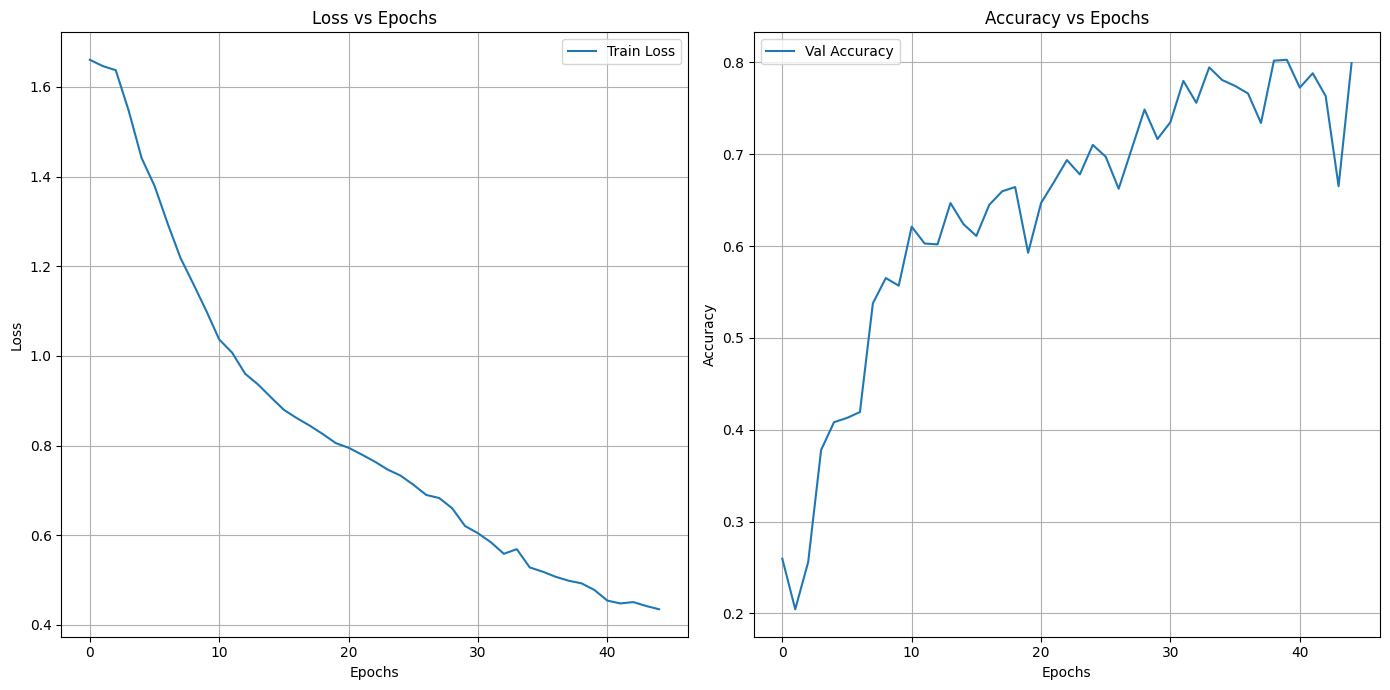

In [91]:
# Plot the two graphs side by side
plt.figure(figsize=(14, 7))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Loss vs Epochs')
plt.legend()
plt.grid(True)

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(valid_accuracies, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title(f'Accuracy vs Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Answer (c):

Some observations and explanations with the plots:
- The generally smooth loss curve, with no sudden jumps or oscillations, suggests the model is learning effectively and training remains stable across training epochs. The lack of a plateau at the end of the curve suggests there may be room for further improvements, but the increasing gentleness of the curves means the model is likely already close to the minimum loss and early stopping is preventing severe overfitting. 
- The generally upward curve for validation accuracy shows that the model is generalising well and its performance is improving over training epochs. There are sudden jumps in accuracy, suggesting that model performance seems to vary over the validation samples, but the overall trend still shows a healthy improvement over the epochs.


**(d) RNNs produce a hidden vector for each word, instead of the entire sentence. Which methods have you tried in deriving the final sentence representation to perform sentiment classification? Describe all the strategies you have implemented, together with their accuracy scores on the test set.**

### Approach:
Here, the approach is to evaluate how different sentence representation strategies could influence the model's performance across various text categories. We will use the best technique for part (e). Since RNNs generate a hidden vector for each token rather than a single sentence embedding, an important design choice is how to aggregate these hidden states into a fixed-length representation for classification. 

We mainly explored 2 families of approaches:

1. Hidden-State Methods
* Last Hidden State (Default) - Use final hidden state as sentence representation (This approach would be good if we think it captures all preceding context well)
* Average Last k hidden states (k = 2, 3, or 4) - These variants aim to smooth the representation by averaging over the most recent time steps, mitigating the possibility of noise or information loss that can occur when relying solely on the final hidden state, especially for longer sentences

2. Pooling Methods
* Mean Pooling - Computes the average over all time-step hidden states, giving equal weight to each token
* Max Pooling - Takes the elementwise maximum across all time steps
* MeanMax Pooling - Concatenates both the mean and max pooled represenation 
* Sum Pooling - Computes by sums all hidden states, which preserve magnitude information 

Additionally, we chose these methods because they are computationally efficient and reasonable to experiment with in a single hidden-layer RNN as well.

Note: While we could have explored more advanced methods like attention-based representations (e.g. self-attention) and/or architectural variations (e.g. bidirectional RNNs) in this part, we left the the exploration of these strategies to qn 3, as the we believe the focus shifts from representation aggregation to model architecture enhancements there.

In [92]:
# Using model from 2(c), our previous models use last hidden state as sentence representation (default baseline)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_acc = test_loop(model, test_loader)
print(f"Test Accuracy (Baseline) {test_acc:.4f}")

Test Accuracy (Baseline) 0.8300


In [93]:
# Redefine RNN Class for experimentation with different sentence representation techniques
class ClassifierRepresentationRNN(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, representation, dropout=0.0):
        super(ClassifierRepresentationRNN, self).__init__()
        num_embeddings, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float), freeze=False)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, 6) # 6 possible labels
        self.representation = representation

    def forward(self, x):
        embedded = self.embedding(x)
        output, hidden = self.rnn(embedded)

        # Conditional Logic to apply different representation techniques
        if self.representation.startswith('average_last_'):
            last_k = int(self.representation.split('_')[-1])
            k = min(last_k, output.size(1))
            rep = output[:, -k:, :].mean(dim=1)
        elif self.representation == 'max':
            rep, _ = torch.max(output, dim=1)
        elif self.representation == 'mean':
            rep = torch.mean(output, dim=1)
        elif self.representation == 'maxmean':
            max_pooled, _ = torch.max(output, dim=1)
            mean_pooled = torch.mean(output, dim=1)
            rep = (max_pooled + mean_pooled) / 2
        elif self.representation == 'sum':
            rep = torch.sum(output, dim=1)

        hidden = self.dropout(rep)
        out = self.fc(hidden)
        return out

In [94]:
# Redefine a function for Representation Tests
def representation_test(strategy, batch_size, hidden_dim, lr, optimizer, no_epoch, weight_decay, dropout, grad_clip, max_norm):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

    # Initialise model
    model = ClassifierRepresentationRNN(TEXT.vocab.vectors.numpy() , hidden_dim, strategy, dropout=dropout)

    # Initialise optimiser
    optimizer = optimizer.__class__(model.parameters(), lr=lr, weight_decay=weight_decay)

    criterion = nn.CrossEntropyLoss()

    if grad_clip == True:
        train_losses, _, _, valid_accuracies, _ = training_step(model, train_loader, valid_loader, optimizer, criterion, no_epoch, grad_clip=True, max_norm=max_norm)
    else:
        train_losses, _, _, valid_accuracies, _ = training_step(model, train_loader, valid_loader, optimizer, criterion, no_epoch)

    test_acc = test_loop(model, test_loader)
    print(f"Test Accuracy {strategy}: {test_acc:.4f}") # Evaluate on test accuracy again here

    return {
        'technique': strategy,
        'test_acc': test_acc
    }

In [95]:
# Set ideal hyperparameters from 2(a)
if best_hyperparams["epochs ran"] <= 50:
    no_epoch = 50
elif best_hyperparams["epochs ran"] > 50 & best_hyperparams["epochs ran"] <= 100:
    no_epoch = 100
else:
    no_epoch = 200
batch_size = best_hyperparams["batch_size"]
hidden_dim = best_hyperparams["hidden_dim"]
lr = best_hyperparams["lr"]
optimizer = best_hyperparams["optimizer"]

# Set regularization from 2(b)
dropout = df_all.loc[df_all['test_acc'].idxmax(), 'dropout']
weight_decay = df_all.loc[df_all['test_acc'].idxmax(), 'weight_decay']
grad_clip = df_all.loc[df_all['test_acc'].idxmax(), 'grad_clip']
max_norm = df_all.loc[df_all['test_acc'].idxmax(), 'max_norm']

best_representation_technique = []
best_representation_technique.append({'technique': 'baseline', 'test_acc': test_acc})

# List and try all the methods, and save it to a dataframe
techniques = ['average_last_2', 'average_last_3', 'average_last_4',
              'max', 'mean', 'maxmean', 'sum']

for technique in techniques:
    results = representation_test(technique, batch_size, hidden_dim, lr, optimizer, no_epoch, weight_decay, dropout, grad_clip, max_norm)
    best_representation_technique.append(results)

df_rep = pd.DataFrame(best_representation_technique)

Epoch 1:
Train loss: 1.6598, Train acc: 0.2265
Valid loss: 1.6653, Valid acc: 0.2046
Epoch 2:
Train loss: 1.6482, Train acc: 0.2242
Valid loss: 1.6442, Valid acc: 0.2477
Epoch 3:
Train loss: 1.6424, Train acc: 0.2442
Valid loss: 1.6523, Valid acc: 0.2505
Epoch 4:
Train loss: 1.6201, Train acc: 0.2758
Valid loss: 1.5137, Valid acc: 0.3780
Epoch 5:
Train loss: 1.4723, Train acc: 0.3842
Valid loss: 1.4422, Valid acc: 0.4018
Epoch 6:
Train loss: 1.3892, Train acc: 0.4019
Valid loss: 1.4436, Valid acc: 0.4064
Epoch 7:
Train loss: 1.2962, Train acc: 0.4521
Valid loss: 1.2795, Valid acc: 0.5092
Epoch 8:
Train loss: 1.2265, Train acc: 0.5016
Valid loss: 1.3228, Valid acc: 0.4569
Epoch 9:
Train loss: 1.1498, Train acc: 0.5403
Valid loss: 1.1972, Valid acc: 0.5560
Epoch 10:
Train loss: 1.0710, Train acc: 0.5855
Valid loss: 1.1351, Valid acc: 0.5550
Epoch 11:
Train loss: 1.0255, Train acc: 0.5981
Valid loss: 1.0817, Valid acc: 0.6083
Epoch 12:
Train loss: 0.9840, Train acc: 0.6238
Valid loss: 0.9

In [96]:
# Sort saved dataframe by test accuracy and print it
df_rep_sorted = df_rep.sort_values(by='test_acc', ascending=False)
df_rep_sorted

,technique,test_acc
5,mean,0.864
6,maxmean,0.860
7,sum,0.850
0,baseline,0.830
4,max,0.830
1,average_last_2,0.826
2,average_last_3,0.800
3,average_last_4,0.798


### Answer (d):
Sum pooling showed the best test accuracy out of all the methods, with accuracy of 0.846. To be fair, most of the methods demonstrate a test accuracy that is relatively similar to one another, with the exception of average_last_3 (0.666). Here, we speculate some of the reasons why these results are as such:

1. Global pooling methods such as sum pooling aggregate information from all time steps, which allow the model to capture features from the entire sequence rather than just the final few tokens. In contrast, average-last-k methods only use the most recent hidden states and might lose earlier contextual queues, which could be more important in sentence representation
2. Unlikely mean pooling, sum pooling preserves the magnitude of activations, which could be beneficial when longer or information dense sentence exert stronger influence on the classifier. Again, normalized methods (e.g. mean pooling/average-last-k) methods might dilute such signals, leading to lower performance
3. Averaging several recent hidden states can introduce noisy or redundant representations because adjacent time steps could encode overlapping information, which could possible explain why average_last_3 performed worse than average_last_2 and average_last_4.

**(e) Report topic-wise accuracy (accuracy for each topic) on the test set for the best model you have. Discuss what may cause the difference in accuracies across different topic categories.**

In [97]:
# Set ideal hyperparameters from 2(a)
if best_hyperparams["epochs ran"] <= 50:
    no_epoch = 50
elif best_hyperparams["epochs ran"] > 50 & best_hyperparams["epochs ran"] <= 100:
    no_epoch = 100
else:
    no_epoch = 200
batch_size = best_hyperparams["batch_size"]
hidden_dim = best_hyperparams["hidden_dim"]
lr = best_hyperparams["lr"]
optimizer = best_hyperparams["optimizer"]

# Set regularization from 2(b)
dropout = df_all.loc[df_all['test_acc'].idxmax(), 'dropout']
weight_decay = df_all.loc[df_all['test_acc'].idxmax(), 'weight_decay']
grad_clip = df_all.loc[df_all['test_acc'].idxmax(), 'grad_clip']
max_norm = df_all.loc[df_all['test_acc'].idxmax(), 'max_norm']

# Set best representation technique from 2(d)
strategy = df_rep.loc[df_rep['test_acc'].idxmax(), 'technique']

In [98]:
# Define the labels/topics for TREC dataset
topics = ["DESC", "ENTY", "HUM", "ABBR", "NUM", "LOC"]
topic_datasets = {}

# Rerun training with best hyperparameters, regularisation and representation technique
model = ClassifierRepresentationRNN(TEXT.vocab.vectors.numpy() , hidden_dim, strategy, dropout=dropout)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

# Initialise optimiser
optimizer = optimizer.__class__(model.parameters(), lr=lr, weight_decay=weight_decay)

criterion = nn.CrossEntropyLoss()

if grad_clip == True:
    train_losses, _, _, valid_accuracies, _ = training_step(model, train_loader, valid_loader, optimizer, criterion, no_epoch, grad_clip=True, max_norm=max_norm)
else:
    train_losses, _, _, valid_accuracies, _ = training_step(model, train_loader, valid_loader, optimizer, criterion, no_epoch)


for topic in topics:
    examples = [eg for eg in test_data.examples if eg.label == topic]
    texts = [" ".join(example.text) for example in examples]
    labels = [LABEL.vocab.stoi[example.label] for example in examples]
    topic_datasets[topic] = SentenceDataset(texts, labels, TEXT.vocab.stoi)

# Define function to obtain test accuracy by topic
def test_by_topic(model ,topic_dataset, batch_size, hidden_dim, strategy, dropout, optimizer, lr, weight_decay, grad_clip, max_norm, no_epoch):

    test_acc = test_loop(model, DataLoader(topic_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn))

    return {
        'topic': topic_dataset,
        'test_acc': test_acc
    }


Epoch 1:
Train loss: 1.5599, Train acc: 0.3333
Valid loss: 1.4576, Valid acc: 0.3936
Epoch 2:
Train loss: 1.3892, Train acc: 0.4193
Valid loss: 1.3589, Valid acc: 0.4330
Epoch 3:
Train loss: 1.2760, Train acc: 0.4991
Valid loss: 1.2469, Valid acc: 0.4917
Epoch 4:
Train loss: 1.1591, Train acc: 0.5699
Valid loss: 1.1497, Valid acc: 0.5761
Epoch 5:
Train loss: 1.0623, Train acc: 0.6139
Valid loss: 1.0367, Valid acc: 0.6064
Epoch 6:
Train loss: 0.9411, Train acc: 0.6557
Valid loss: 0.8927, Valid acc: 0.6725
Epoch 7:
Train loss: 0.8231, Train acc: 0.7114
Valid loss: 0.8174, Valid acc: 0.7028
Epoch 8:
Train loss: 0.7417, Train acc: 0.7430
Valid loss: 0.7811, Valid acc: 0.7303
Epoch 9:
Train loss: 0.6792, Train acc: 0.7625
Valid loss: 0.7073, Valid acc: 0.7578
Epoch 10:
Train loss: 0.6320, Train acc: 0.7822
Valid loss: 0.6557, Valid acc: 0.7835
Epoch 11:
Train loss: 0.5753, Train acc: 0.8065
Valid loss: 0.6135, Valid acc: 0.7982
Epoch 12:
Train loss: 0.5469, Train acc: 0.8171
Valid loss: 0.6

In [99]:
# Check length of each topic test dataset
for dataset in topic_datasets.values():
    print(len(dataset))

138
94
65
9
113
81


In [100]:
# Get test accuracy into dataframe and print by topic
acc_by_topic = []

for topic, dataset in topic_datasets.items():
    result = test_by_topic(model, dataset, batch_size, hidden_dim, strategy, dropout, optimizer, lr, weight_decay, grad_clip, max_norm, no_epoch)
    acc_by_topic.append({'topic': topic, 'test_acc': result["test_acc"]})

df_topics = pd.DataFrame(acc_by_topic)
df_topics

,topic,test_acc
0,DESC,0.963768
1,ENTY,0.574468
2,HUM,0.876923
3,ABBR,0.666667
4,NUM,0.858407
5,LOC,0.901235


### Answer (e):
The model performs best on DESC (description) and HUM (human) questions, and performs worst on ENTY (entity) and ABBR (abbreviation) questions. 
- One reason for the poor performance on ENTY questions is that the question type may be more diverse in its type of questions. For example, ENTY questions tend to use “what” or “which” in the question, and these words are used in other topics as well. Compared to the topic HUM which has almost exclusive use of “who”, it would be harder for the model to distinguish ENTY questions for other topics.
- One reason for the poorer performance for ABBR questions is the small number of samples available in the training and testing data. There are only around 70 questions in our training data with 4362 questions, and 9 questions in the test set, which would lead to the model not being as well trained to distinguish ABBR questions, especially on unseen data.


## End of Qn 2